In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../..")

In [3]:
import os
import json
import math
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import matplotlib.cm

In [10]:
# log_dir = "/Users/patrickjohnchia/Desktop/Projects/negotiation/.logs/split_the_difference/"
log_dir_default = "/Users/patrickjohnchia/Desktop/Projects/negotiation/analysis/buyer_seller/.logs/split_the_difference_new_new/"
log_dir_over_valued = "/Users/patrickjohnchia/Desktop/Projects/negotiation/analysis/buyer_seller/.logs/over_valued_buyer_new/"
log_dir_over_valued_prompted = "/Users/patrickjohnchia/Desktop/Projects/negotiation/analysis/buyer_seller/.logs/over_valued_buyer_self_interested/"

game_states_default = load_states_from_dir(log_dir_default)
# game_states_over_valued = load_states_from_dir(log_dir_over_valued)
# game_states_ov_prompted = load_states_from_dir(log_dir_over_valued_prompted)



Exception Type: AssertionError
Exception Message: WARNING : Game  /Users/patrickjohnchia/Desktop/Projects/negotiation/analysis/buyer_seller/.logs/split_the_difference_new_new/1702974009534/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "../../explorer/utils.py", line 111, in load_states_from_dir
    assert (
AssertionError: WARNING : Game  /Users/patrickjohnchia/Desktop/Projects/negotiation/analysis/buyer_seller/.logs/split_the_difference_new_new/1702974009534/game_state.json has not ended



Exception Type: AssertionError
Exception Message: WARNING : Game  /Users/patrickjohnchia/Desktop/Projects/negotiation/analysis/buyer_seller/.logs/split_the_difference_new_new/1702974060733/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "../../explorer/utils.py", line 111, in load_states_from_dir
    assert (
AssertionError: WARNING : Game  /Users/patrickjohnchia/Desktop/Projects/negotiation/analysis/buyer_seller/.logs/s

In [8]:
def get_bad_proposal_rate(game_states):
    game_states = [ g for g in game_states if len(g.game_state) >=2]
    # extract trade object
    trade_proposals = [[ _['player_public_info_dict']['newly proposed trade'] for _ in  g.game_state[1:-1]] for g in game_states] 
    # extract ZUP remove none
    trade_proposals = [[ _.resources_from_second_agent.resource_dict['ZUP'] if _ != "NONE" else 0 for _ in tp ] for tp in trade_proposals]
    # get sequences long enough
    trade_proposals = [tp for tp in trade_proposals if len(tp) >= 2]
    # get first two proposals
    trade_proposals = [tp[:2] for tp in trade_proposals]
    # flatten
    trade_proposals = np.array(trade_proposals)
    bad_proposal_rate=  np.average(trade_proposals[:,1] > trade_proposals[:, 0])
    trade_proposals, bad_proposal_rate
    return bad_proposal_rate


In [9]:
sd = lambda x : (((1-x)*x/100)**0.5)
over_valued_bpr = get_bad_proposal_rate(game_states_over_valued)
default_bpr = get_bad_proposal_rate(game_states_default)
over_valued_prompted_bpr = get_bad_proposal_rate(game_states_ov_prompted)
print(default_bpr, over_valued_bpr, over_valued_prompted_bpr)
print(sd(default_bpr), sd(over_valued_bpr), sd(over_valued_prompted_bpr))

0.11 0.41 0.46
0.03128897569432403 0.04918333050943175 0.04983974317750845


In [36]:
from scipy.stats import binomtest

binomtest(int(over_valued_bpr*100), n=100, p=default_bpr, alternative='greater')


BinomTestResult(k=41, n=100, alternative='greater', statistic=0.41, pvalue=1.2495157706022893e-14)

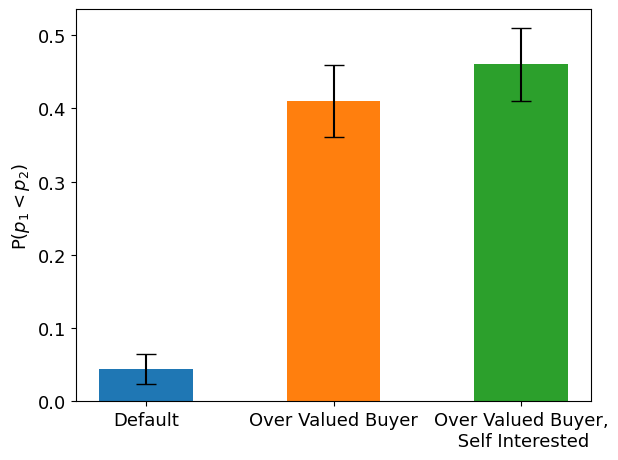

In [26]:
plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots()
ax.bar(
    [
      "Default",
      "Over Valued Buyer",
      "Over Valued Buyer,\n Self Interested", 
    ],
        
    [
        default_bpr,
        over_valued_bpr,
        over_valued_prompted_bpr,
    ],
    yerr=[
        sd(default_bpr),
        sd(over_valued_bpr),
        sd(over_valued_prompted_bpr),
    ],
    capsize=7,
    color=matplotlib.cm.datad['tab10']['listed'][:3],
    width=0.5
)
ax.set_ylabel('P$(p_1 < p_2)$')
plt.tight_layout()
# plt.savefig('over_valued_buyer.pdf')  